# Differential abundance of metabolites

Example of how viral infection changes metabolites in immune cells. 
Data from Li et al 2013, mummichog paper.

In [1]:
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("/Users/lish/li.github/Li_CVK/lcvk")
from metModels import *
from polarPlot import *

In [3]:
cpds = json.load(open('../data/compounds.json'))

In [4]:
cpds['C00559']

{'formula': 'C10H13N5O3',
 'mw': 251.1018,
 'name': "Deoxyadenosine; 2'-Deoxyadenosine",
 'adducts': {}}

In [14]:
# get cpds, smaller in mummichog_nodes
metabolites = []
for line in open('../data/mummichog_Node_attributes.txt').readlines()[1:]:
    a = line.rstrip().split('\t')
    if a[0] in cpds and cpds[a[0]]['formula']:
        metabolites.append({
            'id': a[0],
            'formula': cpds[a[0]]['formula'],
            'name': a[1].split('; ')[0],
            'stat': float(a[2])
        })

In [6]:
edges = []
for line in open('../data/mummichog_activity_network.txt').readlines()[1:]:
    a = line.rstrip().split('\t')
    edges.append((a[0], a[1]))

In [12]:
metabolites[3], edges[:3]

({'id': 'C00062', 'formula': 'C6H14N4O2', 'name': 'L-Arginine', 'stat': -5.29},
 [('C00025', 'C00020'), ('C00025', 'C04376'), ('C00025', 'C00921')])

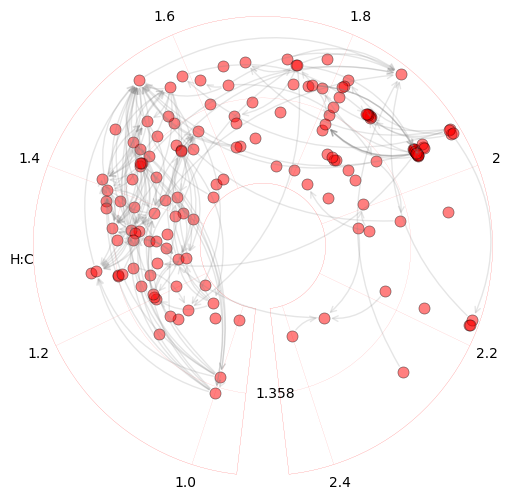

In [17]:
cplot_LCVK_pathway(metabolites, edges, formula='formula', cpd_name='name',
                    title='',  ydata='ratio_NOPS', 
                    width=6, height=6, 
                    rotation=30, show_names=False, yLabel_off=True, 
                    max_radius=2, fontsize=8,
                    marker='o', facecolors='r', linewidths=.5, edgecolors='k', s=64, 
                    edge_alpha=0.2,
                    optimization=True, padding=0.2, 
                    optimization_spacer=0.5, optimization_iter=5,
                    outfile= '../output/mummichog_network__.pdf')

## Fine tune to control node color

In [38]:
from scipy.stats import zscore
from matplotlib import colormaps
cm = colormaps['RdBu']

In [20]:
cm(3.3)

(0.0196078431372549, 0.18823529411764706, 0.3803921568627451, 1.0)

In [21]:
cm(-2)

(0.403921568627451, 0.0, 0.12156862745098039, 1.0)

In [24]:
pathway_nodes, pathway_edges = calculate_clean_network(metabolites, edges, formula='formula', 
                                                        max_H_C_allowed=5)
hcList = [x['ratio_H_C'] for x in pathway_nodes]
cartesian_mean_x, cartesian_min_x, cartesian_max_x = np.mean(hcList), min(hcList), max(1, max(hcList))
# hcList = standardize_data(hcList)
hcList = project_hc_data_radial(hcList)

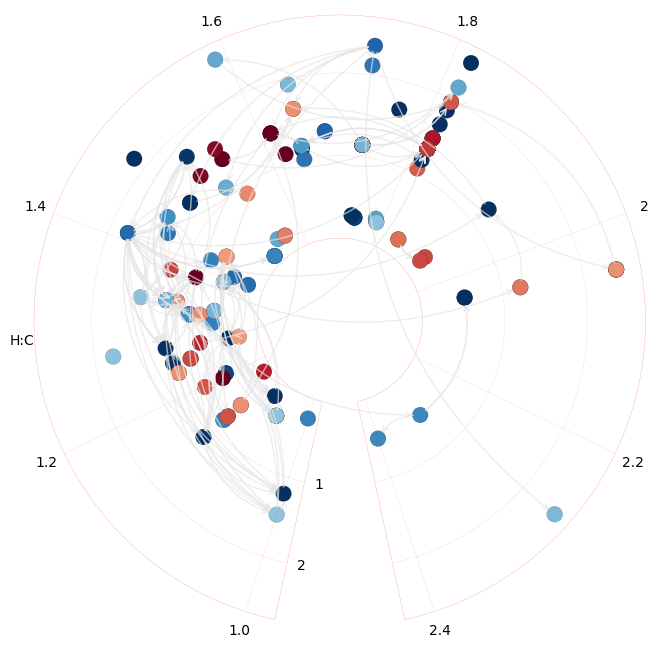

In [44]:
formula='formula' 
cpd_name='name'
width, height =8, 8
min_theta, max_theta =0.1*np.pi, 1.9*np.pi
min_radius, max_radius = 0, 2.5
padding = 0.01
fontsize = 8
rotation = 0

# tick labels; showing original data before polar projection 
xlabels = [ 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4]
xlabels = [x for x in xlabels if cartesian_min_x < x < cartesian_max_x]
if not xlabels:  # data falling out of range, forcing 
    xlabels = [1.0, 1.1]
# xticks = standardize_data(xlabels)
xticks = project_hc_data_radial(xlabels)

ylabels = {'ratio_NOPS': 'NOPS:C', 'ratio_O_C': 'O:C', 'ratio_H_C': 'H:C'} # proper text for axis labels
yList = [min(max(x['ratio_NOPS'], min_radius), max_radius) 
             for x in pathway_nodes]
formulas = [x[formula] for x in pathway_nodes]
names = [x[cpd_name] for x in pathway_nodes]
stats = zscore([ min(max(-10, x['stat']), 10)  for x in pathway_nodes])

layout = dict((x['id'], (hcList[ii], yList[ii])) for ii,x in enumerate(pathway_nodes))

fig = plt.figure(figsize=(width, height))
ax = fig.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('S')
ax.set_theta_direction(-1)
ax.set_thetalim((min_theta - 10*padding, max_theta + 10*padding))
ax.set_ylim(0, 2.7)

ax.scatter(hcList, yList, c=stats, cmap='RdBu',
           marker='o', linewidths=.1, edgecolors='k', s=128, alpha=1, #facecolors='r', 
            )

for edge in pathway_edges: # cleaned edges to use
    ax.annotate("",
        xy=layout[edge[0]], xycoords='data',
        xytext=layout[edge[1]], textcoords='data',
        arrowprops=dict(arrowstyle="<-", color="0.9", alpha=0.7,
                        shrinkA=5, shrinkB=5,
                        patchA=None, patchB=None,
                        connectionstyle="arc3,rad=-0.3",
                        ),
        )

ax.set_rorigin(-1)
for p in ax.spines.values():
    # inner, polar, start, end
    p.set_color('r')
    p.set_linewidth(0.1)
    
median_y = np.median(yList)
ax.set_rgrids([1, 2])
ax.grid(color='r', linewidth=0.05)
# if xticks:
ax.set_xticks(xticks)
ax.set_xticklabels([str(x) for x in xlabels])
ax.text(1.5, max(yList) + .5, "H:C", ) # 

ax.set_title('') 
plt.savefig('../output/mummichog_network_manual.pdf')

## Conclusion

Differential abundance can be mapped via colormap in Matplotlib.